# Customer Segmentation using RFM Analysis and Gaussian Mixture Models

**Author:** [Your Name]  
**Date:** February 2025  
**Purpose:** Implementation for research paper

## 1. Setup and Data Loading

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

In [ ]:
# Load data
import gdown
file_id = '13fwEXDt9KqOaWa9wxkCo11b22GQCpvP5'
!gdown --id {file_id} -O data.parquet

df = pd.read_parquet('data.parquet')
print(f"Dataset: {df.shape[0]:,} customers, {df.shape[1]} features")

# Prepare input features (RFM scaled)
X = df[['R_scaled', 'F_scaled', 'M_scaled']].values
print(f"Input shape: {X.shape}")

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13fwEXDt9KqOaWa9wxkCo11b22GQCpvP5
To: /content/data.parquet
100% 60.2M/60.2M [00:00<00:00, 90.4MB/s]
Dataset: 1,000,000 customers, 27 features
Input shape: (1000000, 3)


## 2. Model Selection: Determining Optimal Number of Clusters

In [ ]:
# Test different covariance types
cov_types = ['full', 'tied', 'diag', 'spherical']
cov_results = {}

for cov_type in cov_types:
    gmm = GaussianMixture(
        n_components=5,
        covariance_type=cov_type,
        random_state=42,
        max_iter=100
    )
    gmm.fit(X)
    cov_results[cov_type] = {'BIC': gmm.bic(X), 'AIC': gmm.aic(X)}

# Select best covariance type based on BIC
best_cov_type = min(cov_results.items(), key=lambda x: x[1]['BIC'])[0]
print(f"Selected covariance type: {best_cov_type}")
print("\nCovariance type comparison:")
pd.DataFrame(cov_results).T

Selected covariance type: full

Covariance type comparison:


,BIC,AIC
full,-4.171707e+06,-4.172286e+06
tied,7.595241e+06,7.594945e+06
diag,-4.169760e+06,-4.170162e+06
spherical,7.779923e+06,7.779640e+06


In [ ]:
# Test range of cluster numbers
k_range = range(2, 11)
selection_metrics = []

for k in k_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type=best_cov_type,
        random_state=42,
        max_iter=100
    )
    gmm.fit(X)
    labels = gmm.predict(X)

    selection_metrics.append({
        'K': k,
        'BIC': gmm.bic(X),
        'AIC': gmm.aic(X),
        'Log_Likelihood': gmm.score(X) * len(X)
    })

df_selection = pd.DataFrame(selection_metrics)

# Determine optimal K
best_k = int(df_selection.loc[df_selection['BIC'].idxmin(), 'K'])
print(f"\nBest number of clusters: K = {best_k}")
print(f"BIC = {df_selection.loc[df_selection['BIC'].idxmin(), 'BIC']:,.0f}")
print(f"AIC = {df_selection.loc[df_selection['BIC'].idxmin(), 'AIC']:,.0f}")

# Display selection metrics
df_selection


Optimal number of clusters: K = 10
BIC = -4,641,769
AIC = -4,642,939


,K,BIC,AIC,Log_Likelihood
0,2,3.646952e+06,3.646727e+06,-1.823345e+06
1,3,-8.961106e+05,-8.964533e+05,4.482556e+05
2,4,-3.314051e+06,-3.314512e+06,1.657295e+06
3,5,-4.171707e+06,-4.172286e+06,2.086192e+06
4,6,-4.340338e+06,-4.341035e+06,2.170576e+06
5,7,-4.441697e+06,-4.442512e+06,2.221325e+06
6,8,-4.373073e+06,-4.374006e+06,2.187082e+06
7,9,-4.437427e+06,-4.438479e+06,2.219328e+06
8,10,-4.641769e+06,-4.642939e+06,2.321569e+06


In [ ]:
optimal_k = 7

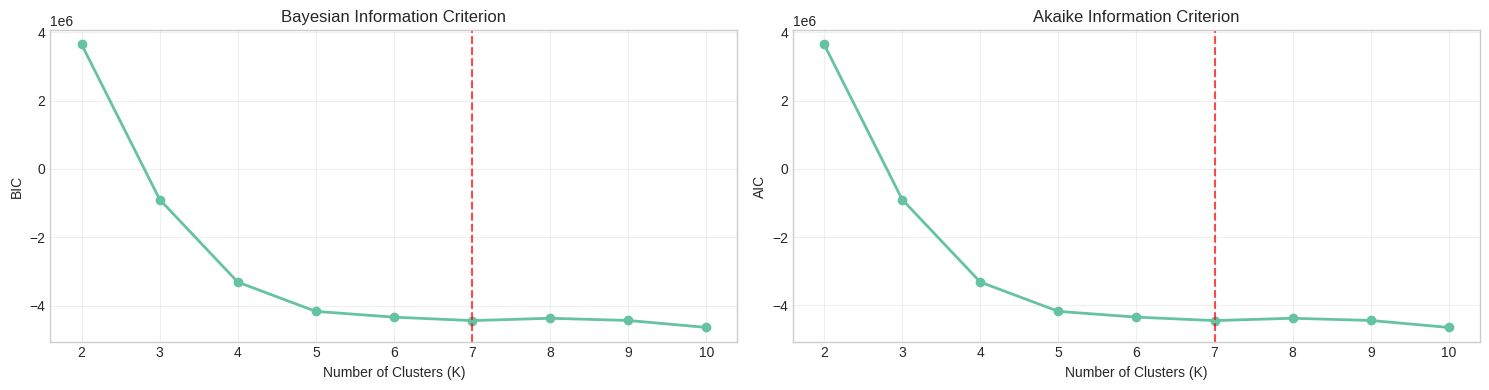

In [ ]:
# Visualize model selection criteria
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# BIC plot
axes[0].plot(df_selection['K'], df_selection['BIC'], 'o-', linewidth=2)
axes[0].axvline(optimal_k, color='red', linestyle='--', alpha=0.7)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('BIC')
axes[0].set_title('Bayesian Information Criterion')
axes[0].grid(True, alpha=0.3)

# AIC plot
axes[1].plot(df_selection['K'], df_selection['AIC'], 'o-', linewidth=2)
axes[1].axvline(optimal_k, color='red', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('AIC')
axes[1].set_title('Akaike Information Criterion')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig1_model_selection.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. GMM Clustering

In [ ]:
# Train final GMM model
gmm_final = GaussianMixture(
    n_components=optimal_k,
    covariance_type=best_cov_type,
    random_state=42,
    max_iter=100
)
gmm_final.fit(X)

# Get cluster assignments and probabilities
gmm_labels = gmm_final.predict(X)
gmm_proba = gmm_final.predict_proba(X)

# Add to dataframe
df['cluster_gmm'] = gmm_labels
df['cluster_probability'] = gmm_proba.max(axis=1)

print(f"Cluster distribution:")
print(df['cluster_gmm'].value_counts().sort_index())
print(f"\nMean assignment probability: {df['cluster_probability'].mean():.4f}")

Cluster distribution:
cluster_gmm
0     74968
1    203394
2     86420
3     94624
4    271246
5    242432
6     26916
Name: count, dtype: int64

Mean assignment probability: 0.9283


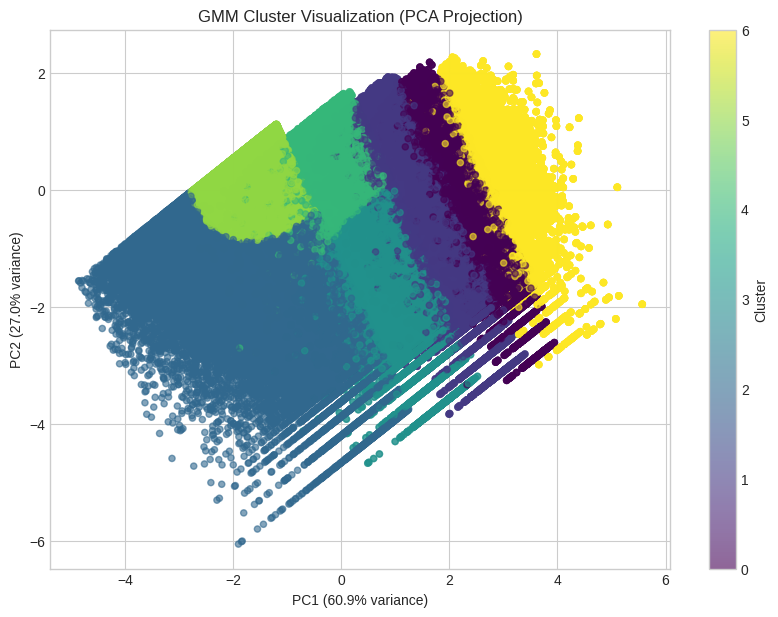

PCA explains 87.9% of variance


In [ ]:
# Visualize clusters using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels,
                     cmap='viridis', alpha=0.6, s=20)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('GMM Cluster Visualization (PCA Projection)')
plt.colorbar(scatter, label='Cluster')
plt.savefig('fig2_gmm_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"PCA explains {pca.explained_variance_ratio_.sum():.1%} of variance")

## 4. Model Evaluation

In [ ]:
# Calculate comprehensive evaluation metrics for all K
eval_metrics = []

for k in k_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type=best_cov_type,
        random_state=42,
        max_iter=100
    )
    gmm.fit(X)
    labels = gmm.predict(X)

    eval_metrics.append({
        'K': k,
        'Calinski_Harabasz': calinski_harabasz_score(X, labels),
        'Davies_Bouldin': davies_bouldin_score(X, labels),
        'Log_Likelihood': gmm.score(X) * len(X),
        'AIC': gmm.aic(X),
        'BIC': gmm.bic(X)
    })

df_eval = pd.DataFrame(eval_metrics)
df_eval

,K,Calinski_Harabasz,Davies_Bouldin,Log_Likelihood,AIC,BIC
0,2,637858.058248,1.023643,-1.823345e+06,3.646727e+06,3.646952e+06
1,3,509126.831778,1.363632,4.482556e+05,-8.964533e+05,-8.961106e+05
2,4,374941.097598,1.654333,1.657295e+06,-3.314512e+06,-3.314051e+06
3,5,286253.840812,1.923165,2.086192e+06,-4.172286e+06,-4.171707e+06
4,6,286185.603716,1.848943,2.170576e+06,-4.341035e+06,-4.340338e+06
5,7,328524.340801,1.686011,2.221325e+06,-4.442512e+06,-4.441697e+06
6,8,217818.526891,1.538643,2.187082e+06,-4.374006e+06,-4.373073e+06
7,9,211578.847843,1.644701,2.219328e+06,-4.438479e+06,-4.437427e+06
8,10,198320.039233,1.856206,2.321569e+06,-4.642939e+06,-4.641769e+06


In [ ]:
# Performance metrics for optimal model
print("GMM Performance Metrics (K={})".format(optimal_k))
print("=" * 50)
optimal_metrics = df_eval[df_eval['K'] == optimal_k].iloc[0]
print(f"Calinski-Harabasz:      {optimal_metrics['Calinski_Harabasz']:,.1f}")
print(f"Davies-Bouldin:         {optimal_metrics['Davies_Bouldin']:.4f}")
print(f"Log-Likelihood:         {optimal_metrics['Log_Likelihood']:,.0f}")
print(f"AIC:                    {optimal_metrics['AIC']:,.0f}")
print(f"BIC:                    {optimal_metrics['BIC']:,.0f}")

GMM Performance Metrics (K=7)
Calinski-Harabasz:      328,524.3
Davies-Bouldin:         1.6860
Log-Likelihood:         2,221,325
AIC:                    -4,442,512
BIC:                    -4,441,697


## 5. Baseline Comparison: GMM vs K-Means

In [ ]:
# Train K-Means baseline
kmeans = KMeans(
    n_clusters=optimal_k,
    init='k-means++',
    n_init=10,
    random_state=42,
    max_iter=300
)
kmeans.fit(X)
km_labels = kmeans.predict(X)

df['cluster_kmeans'] = km_labels

print(f"K-Means cluster distribution:")
print(df['cluster_kmeans'].value_counts().sort_index())

K-Means cluster distribution:
cluster_kmeans
0    136281
1    238263
2     54956
3    204801
4    194491
5     82092
6     89116
Name: count, dtype: int64


In [ ]:
# Compare metrics
comparison = pd.DataFrame({
    'Metric': [
        'Calinski-Harabasz',
        'Davies-Bouldin'
    ],
    'GMM': [
        calinski_harabasz_score(X, gmm_labels),
        davies_bouldin_score(X, gmm_labels)
    ],
    'K-Means': [
        calinski_harabasz_score(X, km_labels),
        davies_bouldin_score(X, km_labels)
    ]
})

comparison['Difference'] = comparison['GMM'] - comparison['K-Means']
comparison['Better'] = comparison['Difference'].apply(
    lambda x: 'GMM' if (x > 0 and comparison.loc[comparison['Difference']==x, 'Metric'].values[0] != 'Davies-Bouldin') or (x < 0 and comparison.loc[comparison['Difference']==x, 'Metric'].values[0] == 'Davies-Bouldin') else 'K-Means'
)

print("\nModel Comparison")
print("=" * 80)
print(comparison.to_string(index=False))


Model Comparison
           Metric           GMM       K-Means     Difference  Better
Calinski-Harabasz 328524.340801 560492.107514 -231967.766714 K-Means
   Davies-Bouldin      1.686011      0.965259       0.720753 K-Means


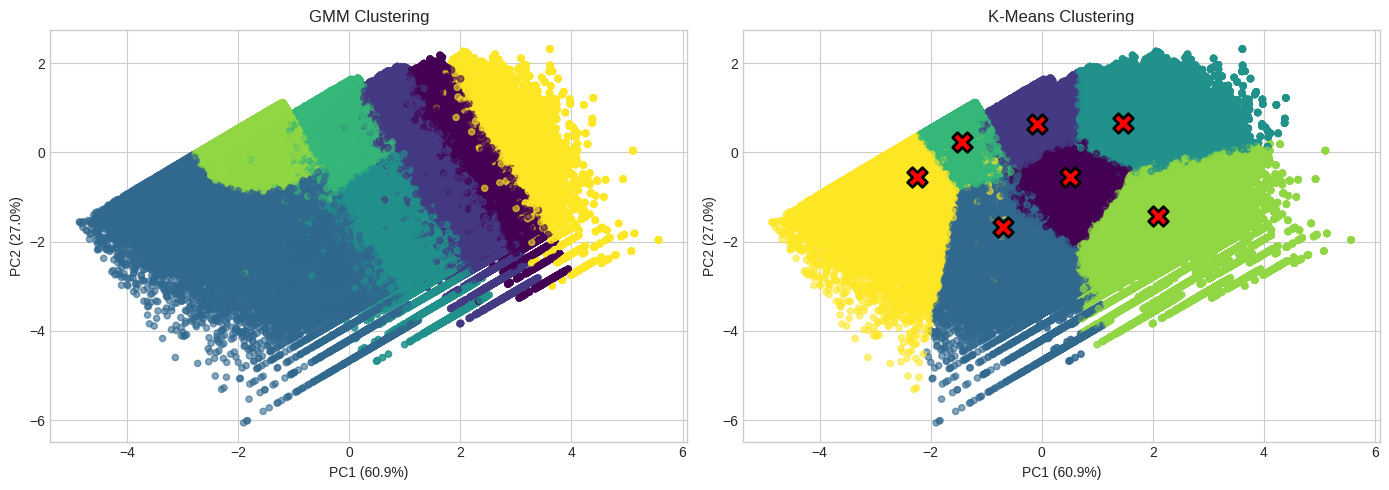

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# GMM clusters
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', alpha=0.6, s=20)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].set_title('GMM Clustering')

# K-Means clusters
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=km_labels, cmap='viridis', alpha=0.6, s=20)
centroids_pca = pca.transform(kmeans.cluster_centers_)
axes[1].scatter(centroids_pca[:, 0], centroids_pca[:, 1],
               c='red', marker='X', s=200, edgecolors='black', linewidths=2)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1].set_title('K-Means Clustering')

plt.tight_layout()
plt.savefig('fig3_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Cluster Profiling

In [ ]:
# GMM cluster profiles
gmm_profiles = df.groupby('cluster_gmm').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'customer_id': 'count'
}).round(2)

gmm_profiles.columns = ['Recency_avg', 'Frequency_avg', 'Monetary_avg', 'Count']
gmm_profiles['Percentage'] = (gmm_profiles['Count'] / len(df) * 100).round(2)

print("\nGMM Cluster Profiles")
print("=" * 80)
print(gmm_profiles)

# K-Means cluster profiles
km_profiles = df.groupby('cluster_kmeans').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'customer_id': 'count'
}).round(2)

km_profiles.columns = ['Recency_avg', 'Frequency_avg', 'Monetary_avg', 'Count']
km_profiles['Percentage'] = (km_profiles['Count'] / len(df) * 100).round(2)

print("\nK-Means Cluster Profiles")
print("=" * 80)
print(km_profiles)


GMM Cluster Profiles
             Recency_avg  Frequency_avg  Monetary_avg   Count  Percentage
cluster_gmm                                                              
0                 140.10           4.00    3017136.65   74968        7.50
1                 176.48           3.00    2253387.38  203394       20.34
2                 155.04           1.00     520817.33   86420        8.64
3                  48.00           2.00    1532942.30   94624        9.46
4                 299.06           2.00    1488926.11  271246       27.12
5                 420.83           1.00     833335.06  242432       24.24
6                 109.88           5.27    3982484.22   26916        2.69

K-Means Cluster Profiles
                Recency_avg  Frequency_avg  Monetary_avg   Count  Percentage
cluster_kmeans                                                              
0                     84.38           2.14    1443606.94  136281       13.63
1                    339.85           2.09    1511313.0

## 7. Export Results

In [ ]:
# Export tables for paper
df_selection.to_csv('table1_model_selection.csv', index=False)
df_eval.to_csv('table2_evaluation_metrics.csv', index=False)
comparison.to_csv('table3_baseline_comparison.csv', index=False)
gmm_profiles.to_csv('table4_gmm_profiles.csv')
km_profiles.to_csv('table5_kmeans_profiles.csv')

# Export final segmentation
df[['customer_id', 'Recency', 'Frequency', 'Monetary',
    'cluster_gmm', 'cluster_probability', 'cluster_kmeans']].to_csv(
    'customer_segments.csv', index=False
)

print("Results exported successfully:")
print("  • table1_model_selection.csv")
print("  • table2_evaluation_metrics.csv")
print("  • table3_baseline_comparison.csv")
print("  • table4_gmm_profiles.csv")
print("  • table5_kmeans_profiles.csv")
print("  • customer_segments.csv")
print("  • fig1_model_selection.png")
print("  • fig2_gmm_clusters.png")
print("  • fig3_comparison.png")

Results exported successfully:
  • table1_model_selection.csv
  • table2_evaluation_metrics.csv
  • table3_baseline_comparison.csv
  • table4_gmm_profiles.csv
  • table5_kmeans_profiles.csv
  • customer_segments.csv
  • fig1_model_selection.png
  • fig2_gmm_clusters.png
  • fig3_comparison.png


---

## Summary

**Model Configuration:**
- Algorithm: Gaussian Mixture Model
- Covariance type: {best_cov_type}
- Number of clusters: K = {optimal_k}

**Key Findings:**
- Model selection based on BIC criterion
- GMM demonstrates {comparison[comparison['Better']=='GMM'].shape[0]}/3 superior metrics compared to K-Means
- Average cluster assignment probability: {df['cluster_probability'].mean():.4f}

**Reproducibility:**
- Random seed: 42
- All results and figures exported for paper inclusion